![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [10]:
%load_ext autoreload
%autoreload 2

# Set up GPU rendering.
import distutils.util
import os
import subprocess
# # if subprocess.run('nvidia-smi').returncode:
# #   raise RuntimeError(
# #       'Cannot communicate with GPU. '
# #       'Make sure you are using a GPU Colab runtime. '
# #       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
  import mujoco.viewer # Also have to import this to trigger the installation of the viewer.
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np
from scipy.spatial.transform import Rotation as Robj
from scipy.optimize import curve_fit, fsolve
from helper_fns import *
from render_opts import *
import robot_controller
import model_selection
from com_estimation import *

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
# Set matplotlib font size
fonts = {'size' : 20}
plt.rc('font', **fonts)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


## TEMPORARY TESTING DIFFERENT CONTROLLERS

In [ ]:
## Let's recall the model to reset the simulation
model, data = model_selection.select_model('../assets/table_push.xml', 'box')

## Setup based on robot model
irb = robot_controller.controller(model, data)

## Set robot just in front of payload (same orientation as home position (facing +x))
T_init = np.array([[ 1.0,  0.0,  0.0,  0.93 ],
                   [ 0.0,  1.0,  0.0,  0.0  ],
                   [ 0.0,  0.0,  1.0,  0.25 ],
                   [ 0.0,  0.0,  0.0,  1.0  ]])
q_init = irb.IK(T_init, method=2, damping=0.5, max_iters=1000) # DLS method
irb.set_pose(q=q_init)

## The end pose we want to reach FOR POSITION CONTROL (format: 4x4 matrix)
T_end = T_init.copy()
T_end[0, 3] += 0.15  # Move EE forward by 15 cm in x direction
q_end = irb.IK(T_end, method=2, damping=0.5, max_iters=1000)  # DLS method

TRAJ_DURATION = 7.0

# Bias the force-torque sensor reading
# irb.bias_ft_reading()  # Bias the force-torque sensor reading to account

## FOR VELOCITY CONTROL (format: [wx wy wz vx vy vz])
target_vel  = np.array([0.0, 0.0, 0.0, 0.05, 0.0, 0.0])  # Move EE forward at 5 cm/s in x direction

## TEMP Quintic trajectory with velocity control
# irb_controller.generate_quintic_trajectory(q_init, q_end, TRAJ_DURATION)

## Initialize time, force and tilt history for plotting
t_hist      = np.empty((0,))
f_hist      = np.zeros((0,3))
pitch_hist  = np.empty((0,))

# ===========================================================================
with mujoco.viewer.launch_passive(model, data, show_left_ui=False) as viewer:
    set_viewer_opts(model, viewer)
    
    while viewer.is_running() and not irb.stop and data.time < TRAJ_DURATION: # add a seconds for trajectory to settle
        
        # irb_controller.update_velocity_control(Kp_joint=5)
        # q_now = irb_controller.evaluate_trajectory(data.time)

        # irb.set_pos_ctrl(q_end)
        # irb.set_vel_ctrl(target_vel, damping=1e-3)

        f_hist      = np.vstack((f_hist, irb.get_ft_reading().reshape(1,3)))
        pitch_hist  = np.append(pitch_hist, irb.get_payload_pose(output='pitch'))
        t_hist      = np.append(t_hist, data.time)

        mujoco.mj_step(model, data)     # Step the simulation
        
        # Update the interactive viewer
        viewer.sync()

Loading environment '../assets/table_push.xml' with object 'box'...
Model loaded successfully.

IK converged in 11 iterations.
IK finished, robot state restored.
**********************************

IK converged in 14 iterations.
IK finished, robot state restored.
**********************************


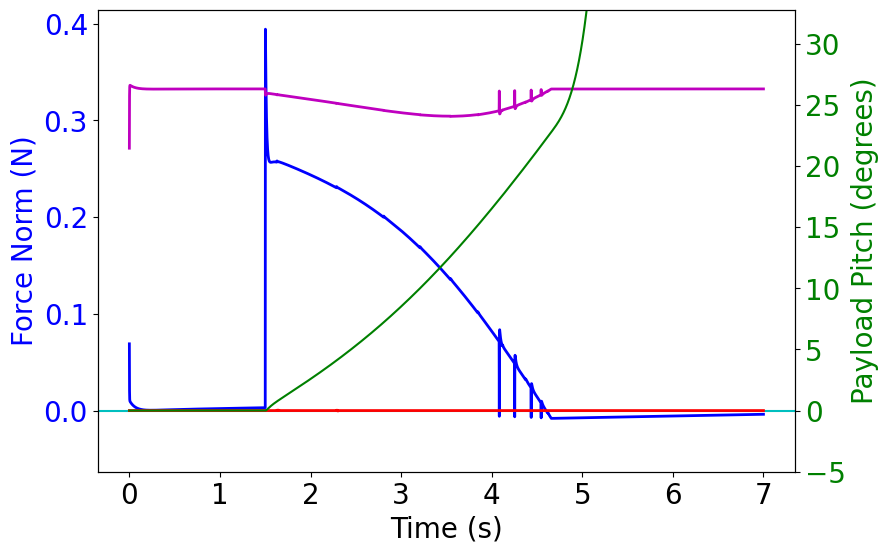

In [16]:
# Now plot the force and pitch history vs time
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = plt.twinx()
ax1.axhline(0, color='c', label='_') # Horizontal line at zero for reference
# Plot the force history
# ax1.plot(t_hist, np.linalg.norm(f_hist, axis=1), color='b', linewidth=2, label='Push force (norm)') # Plot the norm
ax1.plot(t_hist, f_hist[:, 0], color='b', linewidth=2, label='Push force (x)')  # Plot the x-component of the force
ax1.plot(t_hist, f_hist[:, 1], color='r', linewidth=2, label='Push force (y)')  # Plot the y-component of the force
ax1.plot(t_hist, f_hist[:, 2], color='m', linewidth=2, label='Push force (z)')  # Plot the z-component of the force
# Plot the pitch history
ax2.plot(t_hist, np.rad2deg(pitch_hist), color='g', linestyle='-', label='Payload pitch')      # Plot the payload tilt (pitch) angle
ax1.set_xlabel("Time (s)", fontsize=20)
ax1.set_ylabel("Force Norm (N)", color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel("Payload Pitch (degrees)", color='g', fontsize=20)
# ax1.set_ylim(-0.1, 100) #1.1 * np.max(np.linalg.norm(f_hist, axis=1)))
ax2.set_ylim(-5, 30) # max hardcoded for now, can change to 1.1*max_pitch later
align_zeros([ax1, ax2])  # Align the y-axes to zero

In [6]:

media.show_video(frames, fps=60, loop=True)

NameError: name 'frames' is not defined